### Load libraries

In [1]:
from dotenv import load_dotenv
import os

from langchain.chat_models import ChatOpenAI
from langchain.tools import Tool
from langchain.agents import create_openai_tools_agent, AgentExecutor
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_experimental.utilities import PythonREPL



from langchain.tools import Tool
from pydantic import BaseModel

import geopandas as gpd
from shapely.geometry import Point

import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from sqlalchemy import create_engine
import psycopg2

import boto3
import pandas as pd

### Load environment variables
I created .env file where I stored different api keys (AWS and openai).

In [2]:
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION")

# Set the OpenAI API key
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

### LLM
I will use chatgpt 4o-mini as llm for this tutorial, You can use another llm models.\
[List of llm models that you can use with langchain](https://python.langchain.com/docs/integrations/chat/#all-chat-models)

In [3]:
# Create the OpenAI chat model
chat = ChatOpenAI(
    model="gpt-4o-mini",  # You can use also "gpt-3.5-turbo" / gpt-4 if you want
    temperature=0.2
)

/var/folders/wb/j4k9h7qx311cp9pg23ddgxdc0000gp/T/ipykernel_23167/1208344978.py:2: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat = ChatOpenAI(


### Data
The data is stored in an S3 cluster. I will upload it and then push it to a PostgreSQL database, allowing an SQL agent to retrieve the data without requiring SQL coding.

##### Read S3

In [4]:
os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
os.environ["AWS_SECRET_ACCESS_KEY"]=AWS_SECRET_ACCESS_KEY
# os.environ["AWS_REGION"]= AWS_REGION

# Initialize S3 client
s3_client = boto3.client("s3")

# Function to list files in an S3 bucket
def list_s3_objects(bucket_name):
    response = s3_client.list_objects_v2(Bucket=bucket_name)
    if "Contents" in response:
        return [obj["Key"] for obj in response["Contents"]]
    return "No files found in the bucket."

# Function to read a file from S3
def read_s3_object(bucket_name, file_key):
    response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
    # content = response["Body"].read().decode("utf-8")
    content = pd.read_csv(response["Body"])
    return content


In [5]:
list_s3_objects("earthquakedb")

['data_etl.csv']

In [6]:
df = read_s3_object("earthquakedb", "data_etl.csv")
df.head(10)

,Unnamed: 0,Year,Local_Time,UTC_Time,Magnitude,Location,Depth,Latitude,Longitude,Event_type,Assessment,Agency
0,0,2025,Feb 11 01:04:40,Feb 11 00:04:40,1.1,Zinal VS,6.7,46.15,7.71,NaN,automatic,SED
1,1,2025,Feb 10 22:50:01,Feb 10 21:50:01,0.7,Leukerbad VS,6.1,46.37,7.57,earthquake,manual,SED
2,2,2025,Feb 10 18:03:43,Feb 10 17:03:43,0.5,Chamonix F,5.9,45.90,7.01,earthquake,manual,SED
3,3,2025,Feb 10 14:35:00,Feb 10 13:35:00,0.7,Sanetschpass VS,3.1,46.32,7.34,earthquake,manual,SED
4,4,2025,Feb 10 07:59:28,Feb 10 06:59:28,1.6,Bourg-Saint-Pierre VS,5.4,45.93,7.04,earthquake,manual,SED
5,5,2025,Feb 10 07:29:21,Feb 10 06:29:21,1.1,Aosta I,10.3,45.80,7.44,earthquake,manual,SED
6,6,2025,Feb 10 02:12:57,Feb 10 01:12:57,0.6,Aosta I,8.9,45.80,7.43,earthquake,manual,SED
7,7,2025,Feb 10 02:07:45,Feb 10 01:07:45,1.9,Aosta I,9.2,45.80,7.44,earthquake,manual,SED
8,8,2025,Feb 10 02:07:20,Feb 10 01:07:20,1.9,Aosta I,8.0,45.80,7.44,earthquake,manual,SED
9,9,2025,Feb 09 20:54:11,Feb 09 19:54:11,0.2,Bourg-Saint-Pierre VS,4.4,45.93,7.04,earthquake,manual,SED


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8746 entries, 0 to 8745
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8746 non-null   int64  
 1   Year        8746 non-null   int64  
 2   Local_Time  8746 non-null   object 
 3   UTC_Time    8746 non-null   object 
 4   Magnitude   8746 non-null   float64
 5   Location    8746 non-null   object 
 6   Depth       8746 non-null   float64
 7   Latitude    8746 non-null   float64
 8   Longitude   8746 non-null   float64
 9   Event_type  8745 non-null   object 
 10  Assessment  8746 non-null   object 
 11  Agency      8746 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 820.1+ KB


#### Assign Canton name

In [13]:
# Load the Swiss cantons Shapefile
# Ensure you provide the correct path to your Shapefile
shapefile_path = "../Utils/shp/swissBOUNDARIES3D_1_5_TLM_KANTONSGEBIET.shp"

regions_gdf = gpd.read_file(shapefile_path)
if regions_gdf.crs is None:
        regions_gdf.set_crs("EPSG:4326", inplace=True)  # Assuming WGS84

# Convert points list to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(df["Longitude"], df["Latitude"])]
points_gdf = gpd.GeoDataFrame(
        df,geometry=geometry,  # Create Point geometry
        crs="EPSG:4326"  # Set coordinate reference system
)
if regions_gdf.crs != points_gdf.crs:
        regions_gdf = regions_gdf.to_crs(points_gdf.crs)
joined = gpd.sjoin(points_gdf, regions_gdf, how="left", predicate="within")
joined = joined[joined["OBJEKTART"]=="Kanton"]
data = joined[["Unnamed: 0", "Year", "Local_Time", "Magnitude", "Location", "Latitude", "Longitude", "NAME"]]
data.head(10)

,Unnamed: 0,Year,Local_Time,Magnitude,Location,Latitude,Longitude,NAME
0,0,2025,Feb 11 01:04:40,1.1,Zinal VS,46.15,7.71,Valais
1,1,2025,Feb 10 22:50:01,0.7,Leukerbad VS,46.37,7.57,Valais
3,3,2025,Feb 10 14:35:00,0.7,Sanetschpass VS,46.32,7.34,Valais
15,15,2025,Feb 08 00:05:51,0.6,Bourg-Saint-Pierre VS,45.93,7.05,Valais
17,17,2025,Feb 08 20:58:09,2.0,Bourg-Saint-Pierre VS,45.93,7.05,Valais
22,22,2025,Feb 08 08:53:07,2.3,Bourg-Saint-Pierre VS,45.93,7.05,Valais
24,24,2025,Feb 08 05:51:33,1.3,Bourg-Saint-Pierre VS,45.94,7.05,Valais
25,25,2025,Feb 08 05:18:55,0.6,Bourg-Saint-Pierre VS,45.93,7.05,Valais
26,26,2025,Feb 08 03:55:23,1.8,Bourg-Saint-Pierre VS,45.94,7.05,Valais
31,31,2025,Feb 08 01:46:32,0.8,Bourg-Saint-Pierre VS,45.93,7.05,Valais


##### Load S3 data into postgres table

#### Create database

In [14]:
# PostgreSQL credentials
db_host = "localhost"
db_user = "postgres"
db_pass = "postgres"
db_port = "5432"  # Default PostgreSQL port
db_name = "llm_sql"

In [15]:
# Create database
try:
    conn = psycopg2.connect(
        dbname="postgres", user=db_user, password=db_pass, host=db_host, port=db_port
    )
    conn.autocommit = True
    cursor = conn.cursor()
    cursor.execute(f"CREATE DATABASE {db_name};")
    cursor.close()
    conn.close()
    print(f"Database '{db_name}' created successfully.")
except psycopg2.errors.DuplicateDatabase:
    print(f"Database '{db_name}' already exists.")
except Exception as e:
    print(f"Error creating database: {e}")


Database 'llm_sql' already exists.


##### Create table and push data

In [16]:
from sqlalchemy import create_engine, Column, Integer, String, Float, MetaData, Table, DateTime
from sqlalchemy.exc import SQLAlchemyError

# Create a PostgreSQL engine
engine = create_engine(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

In [18]:
from sqlalchemy.exc import NoSuchTableError

metadata_obj = MetaData()
table_name = "earthquakes"

try:
    table = Table(table_name, metadata_obj, autoload_with=engine)
    table.drop(engine)
    print(f"Table '{table_name}' deleted successfully.")
except NoSuchTableError:
    print(f"Table '{table_name}' does not exist.")

Table 'earthquakes' does not exist.


In [19]:

# Sample DataFrame
# data = read_s3_object("earthquakedb", "data_etl.csv")
data = data.rename(columns={"Unnamed: 0":   "Index",
                            "Location":     "location",
                            "Magnitude":    "magnitude",
                            "Latitude":     "latitude",
                            "Longitude":    "longitude",
                            "NAME":         "canton"})
data = data[["Index", "Year", "Local_Time", "magnitude", "location", "latitude", "longitude", "canton"]]
data = data[(data["magnitude"]>=2) & (data["Year"]>=2018)]

data["local_Time"] = pd.to_datetime(data["Year"].astype(str) + " " + data["Local_Time"],
                                    format="%Y %b %d %H:%M:%S")
data.drop(columns=["Year", "Local_Time"], inplace=True)

# Define your table schema
earthquake_table = Table(
    "earthquakes", metadata_obj,
    Column("Index", Integer, primary_key=True, autoincrement=True),
    Column("local_time", DateTime),
    Column("magnitude", Float),
    Column("location", String(255)),
    Column("latitude", Float),
    Column("longitude", Float),
    Column("canton", String(255))
)

# Create the table if it does not exist
try:
    metadata_obj.create_all(engine)
    print("Table created (if not exists).")
except SQLAlchemyError as e:
    print(f"Error creating table: {e}")

# Push the DataFrame into PostgreSQL (replace table if it exists)
data.to_sql('earthquakes', engine, if_exists='replace', index=False)

print("Data successfully pushed to PostgreSQL!")

Table created (if not exists).
Data successfully pushed to PostgreSQL!


##### Test
To test, I am retrieving first 10 records.

In [20]:
query = "SELECT * FROM earthquakes LIMIT 10;"
pd.read_sql(query, engine)

,Index,magnitude,location,latitude,longitude,canton,local_Time
0,17,2.0,Bourg-Saint-Pierre VS,45.93,7.05,Valais,2025-02-08 20:58:09
1,22,2.3,Bourg-Saint-Pierre VS,45.93,7.05,Valais,2025-02-08 08:53:07
2,171,2.3,Lausanne VD,46.51,6.74,Vaud,2025-01-15 05:11:13
3,243,2.1,Samnaun GR,46.90,10.31,Graubünden,2025-01-06 15:23:19
4,245,2.3,Cevio TI,46.34,8.55,Ticino,2025-01-06 09:56:49
5,249,2.2,Kreuzlingen TG,47.63,9.21,Thurgau,2025-01-05 16:54:55
6,254,2.0,Savognin GR,46.59,9.57,Graubünden,2025-01-03 15:29:42
7,270,2.2,Boncourt JU,47.48,7.01,Jura,2024-12-31 07:33:28
8,350,2.4,Weinfelden TG,47.60,9.08,Thurgau,2024-12-20 16:17:11
9,396,2.3,Sanetschpass VS,46.33,7.39,Valais,2024-12-13 08:24:30


### SQL Agent

In [21]:


db = SQLDatabase.from_uri(f'postgresql://{db_user}:{db_pass}@{db_host}:{db_port}/{db_name}')

# Create a SQLDatabase Toolkit (this contains the necessary tools)
toolkit = SQLDatabaseToolkit(db=db, llm=chat)


In [22]:
tools = toolkit.get_tools()
print([tool.name for tool in tools])

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker']


In [23]:
# Define prompt
# prompt = ChatPromptTemplate.from_template("{input}")
prompt = ChatPromptTemplate.from_template(
    "{input}\n\nPrevious Actions:\n{agent_scratchpad}"
)

# Create LangChain SQL agent
sql_agent = create_openai_tools_agent(
    llm=chat,
    tools=tools,
    prompt=prompt,
)

# Create agent executor
agent_executor = AgentExecutor(agent=sql_agent,
                               tools=tools,
                               verbose=False)

### Simple questions

- 10 first records

In [24]:
response1 = agent_executor.invoke({"input": "Display the first 10 records from the earthquakes table."})
print(response1['output'])

Here are the first 10 records from the earthquakes table:

1. **ID:** 17, **Magnitude:** 2.0, **Location:** Bourg-Saint-Pierre VS, **Latitude:** 45.93, **Longitude:** 7.05, **Region:** Valais, **Date:** 2025-02-08 20:58:09
2. **ID:** 22, **Magnitude:** 2.3, **Location:** Bourg-Saint-Pierre VS, **Latitude:** 45.93, **Longitude:** 7.05, **Region:** Valais, **Date:** 2025-02-08 08:53:07
3. **ID:** 171, **Magnitude:** 2.3, **Location:** Lausanne VD, **Latitude:** 46.51, **Longitude:** 6.74, **Region:** Vaud, **Date:** 2025-01-15 05:11:13
4. **ID:** 243, **Magnitude:** 2.1, **Location:** Samnaun GR, **Latitude:** 46.90, **Longitude:** 10.31, **Region:** Graubünden, **Date:** 2025-01-06 15:23:19
5. **ID:** 245, **Magnitude:** 2.3, **Location:** Cevio TI, **Latitude:** 46.34, **Longitude:** 8.55, **Region:** Ticino, **Date:** 2025-01-06 09:56:49
6. **ID:** 249, **Magnitude:** 2.2, **Location:** Kreuzlingen TG, **Latitude:** 47.63, **Longitude:** 9.21, **Region:** Thurgau, **Date:** 2025-01-05

- strongest earthquake recorded

In [25]:
response2 = agent_executor.invoke({"input": "Retrieve the record of the earthquake of the most magnitude"})
print(response2['output'])

The record of the earthquake with the highest magnitude is as follows:

- **ID**: 909
- **Magnitude**: 4.4
- **Location**: Pragelpass GL/SZ
- **Latitude**: 47.05
- **Longitude**: 8.86
- **Region**: Schwyz
- **Date and Time**: June 4, 2024, 02:34:32

If you need more information or further assistance, feel free to ask!


- Oldest record

In [26]:
response4 = agent_executor.invoke({"input": "when was the oldest record in earthquake table."})
print(response4['output'])

The oldest record in the `earthquakes` table is from July 2, 2019, at 01:13:57.


- Region with most earthquakes

In [27]:
response5 = agent_executor.invoke({"input": "In which swiss Location occurs the most earthquakes."})
print(response5['output'])

The location in Switzerland that experiences the most earthquakes is Elm GL, with a total of 42 recorded earthquakes.


In [28]:
response6 = agent_executor.invoke({"input": "In which swiss canton occurs the most earthquakes"})
print(response6['output'])

The Swiss canton that experiences the most earthquakes is Valais, with a total of 109 recorded earthquakes.


In [29]:
response7 = agent_executor.invoke({"input": "Give me top 5 swiss cantons with the most earthquakes"})
print(response7['output'])

The top 5 Swiss cantons with the most earthquakes are:

1. **Valais** - 109 earthquakes
2. **Graubünden** - 44 earthquakes
3. **Glarus** - 43 earthquakes
4. **Jura** - 32 earthquakes
5. **Bern** - 16 earthquakes


### Ask openai to make a plot

##### Add new tool (Matplotlib)

In [30]:
python_repl = PythonREPL()
repl_tool = Tool(
    name="python_repl",
    description="Executes python code and returns the result. The code runs in a static sandbox without interactive mode, so print output or save output to a file.",
    func=python_repl.run,
)
repl_tool.name = "python_interpreter"

In [31]:
tools = toolkit.get_tools()
tools.append(repl_tool)
print([tool.name for tool in tools])

['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker', 'python_interpreter']


In [32]:
# Define prompt
# prompt = ChatPromptTemplate.from_template("{input}")
prompt = ChatPromptTemplate.from_template(
    "{input}\n\nPrevious Actions:\n{agent_scratchpad}"
)

# Create LangChain SQL agent
sql_agent = create_openai_tools_agent(
    llm=chat,
    tools=tools,
    prompt=prompt,
)

# Create agent executor
agent_executor = AgentExecutor(agent=sql_agent,
                               tools=tools,
                               verbose=False)

Python REPL can execute arbitrary code. Use with caution.


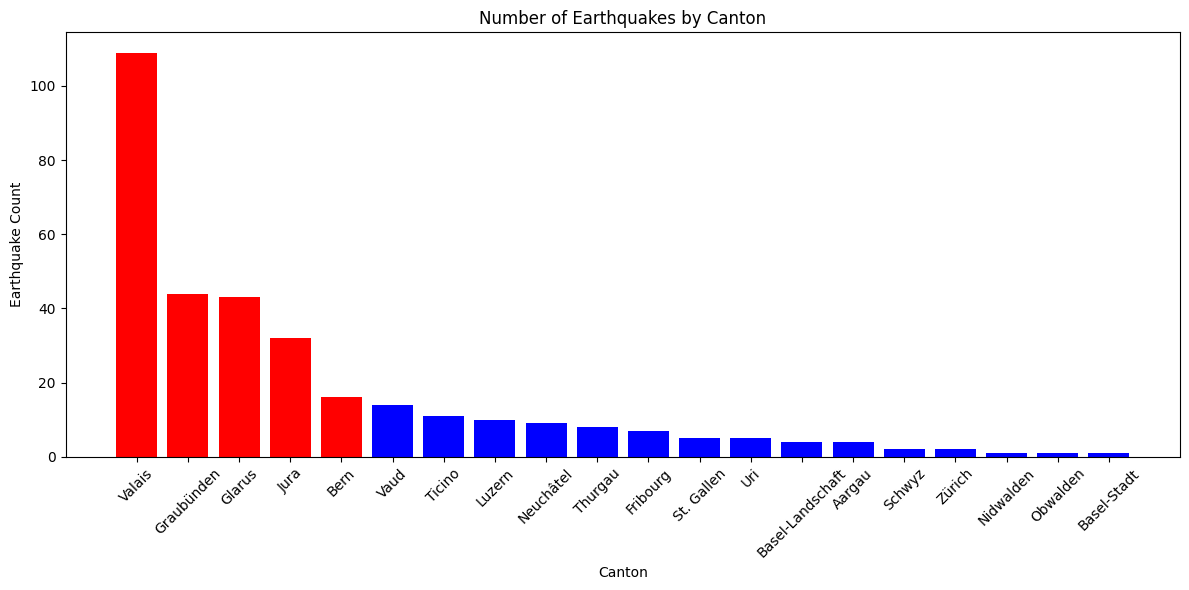

{'input': 'Count number of earthquakes for each canton and plot it by order descendant of earthquakes. Top 5 cantons in red.',
 'output': 'The analysis of the number of earthquakes by canton has been completed, and the results have been plotted. The top 5 cantons with the highest number of earthquakes are highlighted in red. \n\nHere are the counts of earthquakes for each canton:\n\n1. Valais: 109\n2. Graubünden: 44\n3. Glarus: 43\n4. Jura: 32\n5. Bern: 16\n6. Vaud: 14\n7. Ticino: 11\n8. Luzern: 10\n9. Neuchâtel: 9\n10. Thurgau: 8\n11. Fribourg: 7\n12. St. Gallen: 5\n13. Uri: 5\n14. Basel-Landschaft: 4\n15. Aargau: 4\n16. Schwyz: 2\n17. Zürich: 2\n18. Nidwalden: 1\n19. Obwalden: 1\n20. Basel-Stadt: 1\n\nIf you have any further questions or need additional analysis, feel free to ask!'}

In [33]:
agent_executor.invoke({"input": "Count number of earthquakes for each canton and plot it by order descendant of earthquakes. Top 5 cantons in red."})

##### New tool (geopandas)

In [34]:
# Load Swiss cantons shapefile
swiss_cantons = gpd.read_file(shapefile_path)

# Input Schema
class CantonPlotInput(BaseModel):
    canton_data: list  # List of {"canton": "ZH", "count": 10}

def plot_canton_data(canton_data: list):
    """
    Plots Swiss cantons, shading them based on earthquake counts.

    Parameters:
        canton_data (list): List of {"canton": "ZH", "count": 10}.

    Returns:
        str: Path to saved plot image.
    """
    try:
        # Convert input to DataFrame
        df = pd.DataFrame(canton_data)
        df.rename(columns={'canton': 'Name', 'count': 'Count'}, inplace=True)

        # Merge with Swiss cantons GeoDataFrame
        merged = swiss_cantons.merge(df, left_on="NAME", right_on="Name", how="left").fillna(0)

        # Plot
        fig, ax = plt.subplots(figsize=(10, 6))
        merged.plot(column="Count", cmap="OrRd", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

        # Hide axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_title("Earthquake Occurrences by Canton in Switzerland")

        # Save plot
        plot_path = "canton_earthquakes.png"
        plt.title("Earthquakes per Swiss Canton")
        plt.savefig(plot_path)
        plt.close()

        return f"GeoPlot saved as {plot_path}"

    except Exception as e:
        return f"Error in plotting: {str(e)}"

# Define LangChain Tool
geo_plot_tool = Tool(
    name="canton_plotter",
    description="Plots Swiss cantons, shading them based on earthquake counts. Takes a list of {'canton': 'ZH', 'count': 10}.",
    func=plot_canton_data,
    args_schema=CantonPlotInput
)

# Add tool to SQL agent
tools = toolkit.get_tools()
tools.append(geo_plot_tool)

# Verify tools
print([tool.name for tool in tools])


['sql_db_query', 'sql_db_schema', 'sql_db_list_tables', 'sql_db_query_checker', 'canton_plotter']


In [35]:
# Define prompt
# prompt = ChatPromptTemplate.from_template("{input}")
prompt = ChatPromptTemplate.from_template(
    "{input}\n\nPrevious Actions:\n{agent_scratchpad}"
)

# Create LangChain SQL agent
sql_agent = create_openai_tools_agent(
    llm=chat,
    tools=tools,
    prompt=prompt,
)

# Create agent executor
agent_executor = AgentExecutor(agent=sql_agent,
                               tools=tools,
                               verbose=True)

In [36]:
agent_executor.invoke({"input": "Count number of earthquakes for each canton and plot it by order descendant of earthquakes."})



> Entering new AgentExecutor chain...

Invoking: `sql_db_list_tables` with `{}`


earthquakes
Invoking: `sql_db_query` with `{'query': 'SELECT canton, COUNT(*) AS earthquake_count FROM earthquakes GROUP BY canton ORDER BY earthquake_count DESC;'}`


[('Valais', 109), ('Graubünden', 44), ('Glarus', 43), ('Jura', 32), ('Bern', 16), ('Vaud', 14), ('Ticino', 11), ('Luzern', 10), ('Neuchâtel', 9), ('Thurgau', 8), ('Fribourg', 7), ('St. Gallen', 5), ('Uri', 5), ('Basel-Landschaft', 4), ('Aargau', 4), ('Schwyz', 2), ('Zürich', 2), ('Nidwalden', 1), ('Obwalden', 1), ('Basel-Stadt', 1)]
Invoking: `canton_plotter` with `{'canton_data': [{'canton': 'Valais', 'count': 109}, {'canton': 'Graubünden', 'count': 44}, {'canton': 'Glarus', 'count': 43}, {'canton': 'Jura', 'count': 32}, {'canton': 'Bern', 'count': 16}, {'canton': 'Vaud', 'count': 14}, {'canton': 'Ticino', 'count': 11}, {'canton': 'Luzern', 'count': 10}, {'canton': 'Neuchâtel', 'count': 9}, {'canton': 'Thurgau', 'count': 8}, {'canton': '

{'input': 'Count number of earthquakes for each canton and plot it by order descendant of earthquakes.',
 'output': 'The number of earthquakes for each canton has been counted and plotted in descending order. The plot has been saved as "canton_earthquakes.png". \n\nIf you need any further analysis or information, feel free to ask!'}

The LLM agent retrieves data for each canton and generates a map plot, using a color gradient from red to yellow based on the number of earthquakes recorded in recent years.

By setting verbose to True, you can observe the steps the LLM agent takes to arrive at the final results.

<img src="canton_earthquakes.png" alt="Alternative text" />